In [188]:
import time
print("Last updated on ", time.asctime())

Last updated on  Tue Oct 23 22:36:28 2018


In [189]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md
import collections       as collections
import pandas            as pd

from   scipy import optimize
from  invisible_cities.core .core_functions import in_range

import krcal.utils.plt_functions          as krplot
import krcal.utils.hst_extend_functions   as hst

In [191]:
# Plotting style
default_cmap = "jet"
figure_size  = 14, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

In [192]:
run_number = 6348
trigger    = 'trigger2'
input_filename = f"$IC_DATA/{run_number}/pmaps/edf_{run_number}_0_5999_{trigger}.h5"
input_file     = os.path.expandvars(input_filename)

In [193]:
hd = pd.HDFStore(input_file)

In [194]:
edf = hd['edf']
edf.head()

,event,peak,loc,nslices,nhits,noqhits,time,s1e,t0,rmax,...,x0,y0,z0,q0,e0,x,y,z,q,e
0,5,0,0,36,372,2241,1538211719116,172.335297,378.170655,168.671278,...,130.133571,-18.673701,283.337372,7713.145020,159915.234375,130.300655,-18.688073,283.386290,8748.018755,167498.445063
1,9,0,0,39,386,2094,1538211719198,171.858398,473.307052,199.123078,...,133.396689,-102.612666,189.165375,8620.006836,153441.796875,133.453533,-102.711659,189.380166,9787.571454,176833.859455
2,47,0,0,25,370,2080,1538211720169,173.360474,531.961168,215.058132,...,-85.901989,-154.502059,129.243164,9986.626953,157533.890625,-85.662095,-154.178045,129.393429,9142.083401,167832.318589
3,160,0,0,14,165,1013,1538211723096,92.094521,523.466149,109.772492,...,-34.129546,66.868263,131.162048,5328.606445,108656.960938,-34.138677,67.106688,131.148393,5495.622372,99119.286446
4,178,0,0,22,317,1344,1538211723388,188.094254,346.333260,224.610774,...,183.196182,-44.830324,312.466980,7616.803711,115633.554688,181.609592,-43.046135,312.466297,8383.785567,154118.578548


In [195]:
edf = edf.dropna()

pk  = edf.peak
E   = edf.e
Q   = edf.q
X   = edf.x
Y   = edf.y
R   = np.sqrt(X*X + Y*Y)
Z   = edf.z
ns  = edf.nslices
nh  = edf.nhits
S1e = edf.s1e
ts  = edf.time
t0  = edf.t0
zmin = edf.zmin
zmax = edf.zmax
rmax = edf.rmax

In [196]:
sel = (zmin > 20) & (zmax < 530.) & (rmax < 170.)
print('number of candidates', np.sum(sel))
#sel = (Z > 50) & (Z < 500.) & (R < 160.)
print('number of candidates', np.sum(sel))


number of candidates 62390
number of candidates 62390


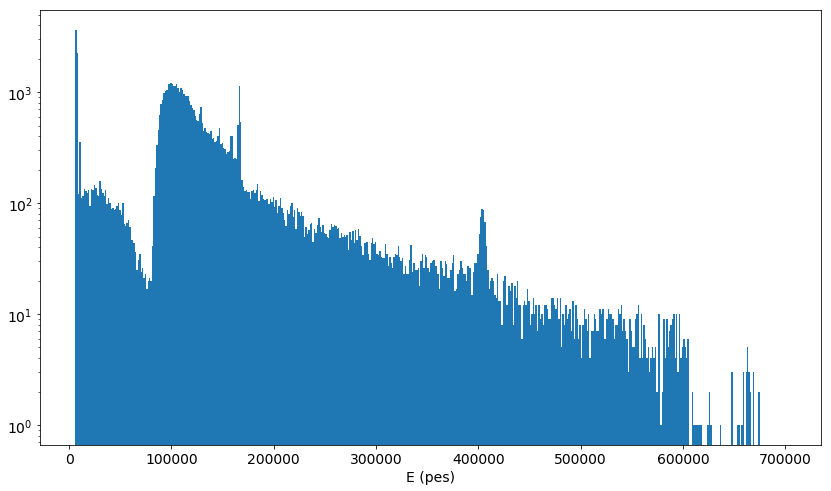

In [197]:
Ea = hst.Vaxis((6.e3, 700.e3), 500)
#c = hst.Canvas(1, 1)
#c(1)
plt.hist(E[sel], Ea.bins);
plt.yscale('log')
plt.xlabel('E (pes)');


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


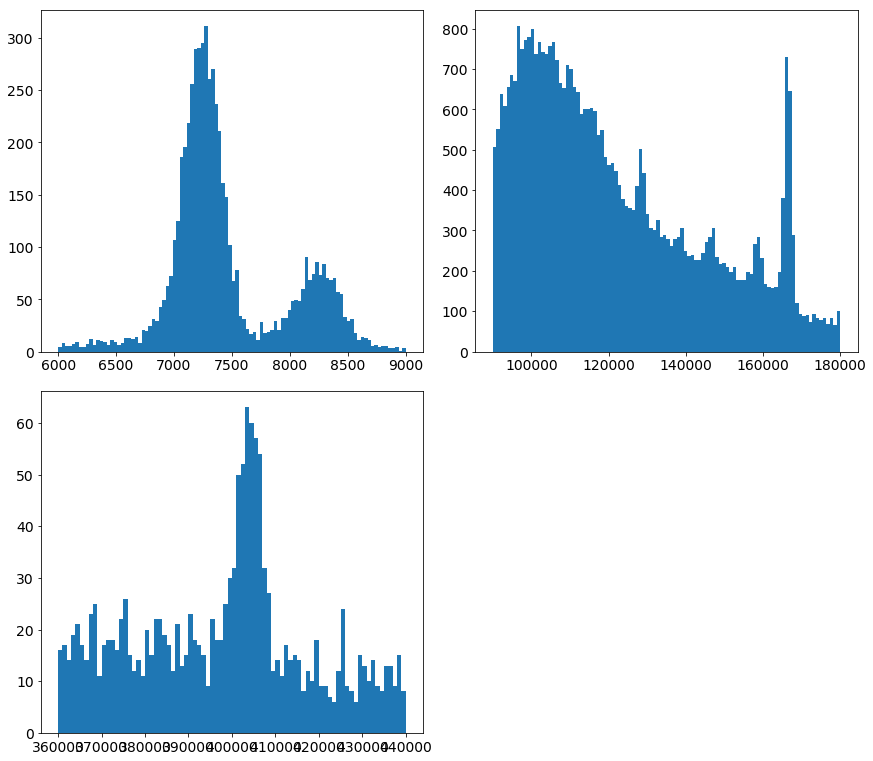

In [200]:
c    = hst.Canvas(2, 2)
c(1)
Exa = hst.Vaxis((6e3, 9.e3), 100)
plt.hist(E[sel], Exa.bins)
#plt.yscale('log')
c(2)
Eca = hst.Vaxis((90e3, 180e3), 100)
plt.hist(E[sel], Eca.bins);
#plt.yscale('log')
c(3)
Eca = hst.Vaxis((360e3, 440e3), 80)
plt.hist(E[sel], Eca.bins);
#plt.yscale('log')
plt.tight_layout()

In [201]:
XYa = hst.Vaxis((-220., 220), 80)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


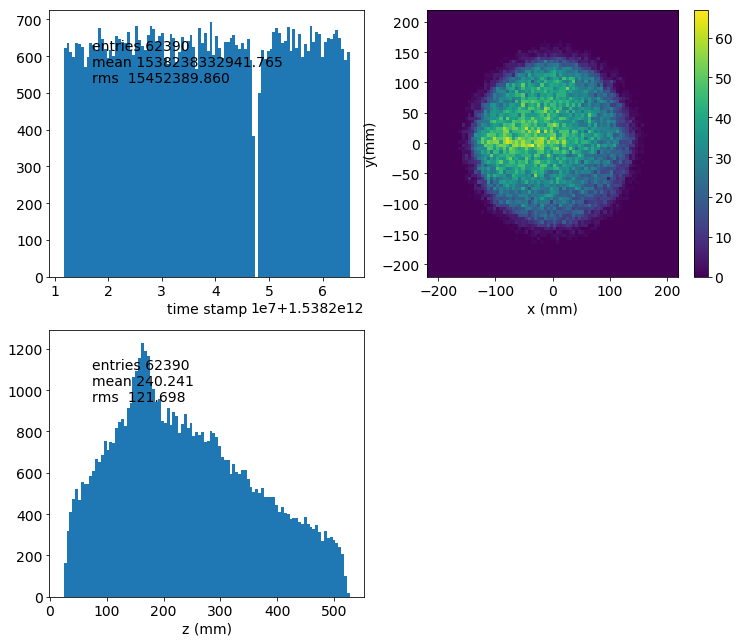

In [202]:
c = hst.Canvas(2, 2)
hst.hist(ts[sel], 100                          , canvas = c(1), xylabels=('time stamp', ''))
hst.hist2d(X[sel], Y[sel], (XYa.bins, XYa.bins), canvas = c(2), xylabels=('x (mm)', 'y(mm)'));
plt.colorbar();
hst.hist(Z[sel], 100                           , canvas = c(3), xylabels=('z (mm)', '' ));
#hst.hist(t0[sel], 100                          , canvas = c(4), xylabels=('t0 (us)', '' ));

In [203]:
def fun_gaus(x, A, mu, sig):
    return A * np.e**(-(x-mu)**2/(2*sig*sig)) 

def fun_gausline(x, A, mu, sig, a, b):
    return A * np.e**(-(x-mu)**2/(2*sig*sig)) + a*x + b

def guess_gaus(v):
    A, mu, sig = len(v), np.mean(v), np.std(v)
    return A, mu, sig

def guess_gausline(v):
    A, mu, sig = guess_gaus(v)
    y, x = np.histogram(v, 10)
    a, b = y[0], (y[-1]-y[0])/(x[-1]-x[0])
    return A, mu, sig, a, b
    
def chisq(F, popt, xdata, ydata):
    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

def fit_fun(x, y, fun, guess):
    popt, pcov = optimize.curve_fit(fun, x, y, p0 = guess, sigma = np.sqrt(y))
#                                    bounds=([-np.inf, 0, -np.inf, -np.inf, 0.], 5*[np.inf, ]))
#    Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    return popt

def text_fitgaus(mu, sig, chi2):
    t = (r"$\mu$ : {}"     .format(round(mu, 1)) + 
         "\n" + "$\sigma$ : {}" .format(round(sig, 1))  +
         "\n" + r"FWHM : {}"    .format(round(sig / mu * 235, 2)) + 
         "\n" + r"$\chi^2$ : {}".format(round(chi2,2))) 
    return t
    
def rel_pos(xcenters, yvals, x0=0.75, y0 = 0.6):
    xi = x0 * (np.max(xcenters)-np.min(xcenters)) + np.min(xcenters)
    yi = y0 * (np.max(yvals)-np.min(yvals))       + np.min(yvals)
    return xi, yi

In [204]:
def plot_gausline(V, xbins, comment=''):
    
    dys, dxs = np.histogram(V, xbins)
    guess = guess_gausline(V)
    plt.hist(V, xbins)
    
    #print('guess parameters    :', guess)
    xcenters = 0.5*(xbins[:-1]+xbins[1:])
    phat = fit_fun(xcenters, dys, fun_gausline, guess)
    plt.plot(dxs, fun_gausline(dxs, *phat), lw=3, ls='--')
    plt.xlabel('E (pes)')
    plt.title(comment)
    #print('estimated parameters: ', phat)
    chi2 = chisq(fun_gausline, phat, xcenters, dys)
    #print('chi2$: ', chi2)

    x0, y0 = rel_pos(xcenters, dys)
    text   = text_fitgaus(phat[1], phat[2], chi2)
    #print(text)
    plt.text(x0, y0, text, fontsize = 11);
    return xcenters, phat, chi2

In [205]:
def plot_fit_multiple_peaks(Ea, Erange_peaks, sel):
    xsel = in_range(E, *Ea.range) & sel

    plt.hist(E[xsel], Ea.bins, alpha = 0.5);
    plt.xlabel('E (pes)')
    ys, xes = np.histogram(E[xsel], Ea.bins)

    def _grange(eini, eend):

        Eka   = hst.Vaxis( (eini, eend), 100)
        xkrsel = in_range(Ea.centers, *Eka.range)
        ekrsel = (in_range(E, *Eka.range)) & sel
        guess = guess_gausline(E[ekrsel])
        krphat = fit_fun(Ea.centers[xkrsel], ys[xkrsel], fun_gausline, guess)
        xx = Ea.centers[xkrsel]
        mu, sig, = krphat[1], abs(krphat[2])
        t = r"$\mu$ : {}".format(round(mu, 1))+ "\t $\sigma$ : {}".format(round(sig, 1))+"\t FWHM : {}".format(round(sig / mu * 235, 2))
        print(t)
        plt.plot(xx, fun_gausline(xx, *krphat), lw=2, ls='--', label = t)

    for ierange in Erange_peaks:
        _grange(*ierange)

    plt.legend();

In [206]:
def plot_E_vs_vars(Ea, sel):
    c = hst.Canvas(3, 2)
    xsel = in_range(E, *Ea.range) & sel
    nbins = Ea.nbins
    eini, eend = Ea.range
    c(1)
    plt.hist2d(Z[xsel], E[xsel], (100, nbins), ((0, 550.), (eini, eend)) );
    plt.xlabel('z (mm)')
    plt.ylabel('E (pes)')
    plt.grid()
    c(2)
    plt.hist2d(R[xsel], E[xsel], (100, nbins), ((0, 220.), (eini, eend)) );
    plt.xlabel('r (mm)')
    plt.ylabel('E (pes)')
    plt.grid()
    c(3)
    plt.hist2d(X[xsel], E[xsel], (100, nbins), ((-200., 200.), (eini, eend)));
    plt.xlabel('x (mm)')
    plt.ylabel('E (pes)')
    plt.grid()
    c(4)
    plt.hist2d(Y[xsel], E[xsel], (100, nbins), ((-200., 200.), (eini, eend)));
    plt.xlabel('y (mm)')
    plt.ylabel('E (pes)')
    plt.grid()
    c(5)
    plt.hist2d(ts[xsel], E[xsel], (100, nbins), ((ts.min(),ts.max()), (eini, eend)));
    plt.xlabel('time (s)')
    plt.ylabel('E (pes)')
    plt.grid()
    plt.tight_layout()

In [214]:
def plot_E_vs_N(Ea, NSa, NHa, sel):
    c = hst.Canvas(1, 2)
    #eini, eend = 6e3, 12e3
    xsel = in_range(E, *Ea.range) & sel
    c(1)
    plt.hist2d(ns[xsel], E[xsel], (NSa.bins, Ea.bins));
    plt.xlabel('number of slices')
    plt.ylabel('E (pes)')
    plt.grid()
    c(2)
    plt.hist2d(nh[xsel], E[xsel], (NHa.bins, Ea.bins));
    plt.xlabel('number of hits')
    plt.ylabel('E (pes)')
    plt.grid()
    plt.tight_layout()

In [217]:
def plot_N_vs_Z(Ea, Za, NSa, NHa, sel):
    c = hst.Canvas(1, 2)
    #eini, eend = 6e3, 12e3
    xsel = in_range(E, *Ea.range) & sel
    c(1)
    plt.hist2d(Z[xsel], ns[xsel], (Za.bins, NSa.bins) );
    plt.ylabel('number of slices')
    plt.xlabel('z (mm)')
    plt.grid()
    c(2)
    plt.hist2d(Z[xsel], nh[xsel], (Za.bins, NHa.bins) );
    plt.ylabel('number of hits')
    plt.xlabel('z (mm)')
    plt.grid()
    plt.tight_layout()

## X-rays

$\mu$ : 8258.2	 $\sigma$ : 169.2	 FWHM : 4.82
$\mu$ : 7250.3	 $\sigma$ : 156.4	 FWHM : 5.07


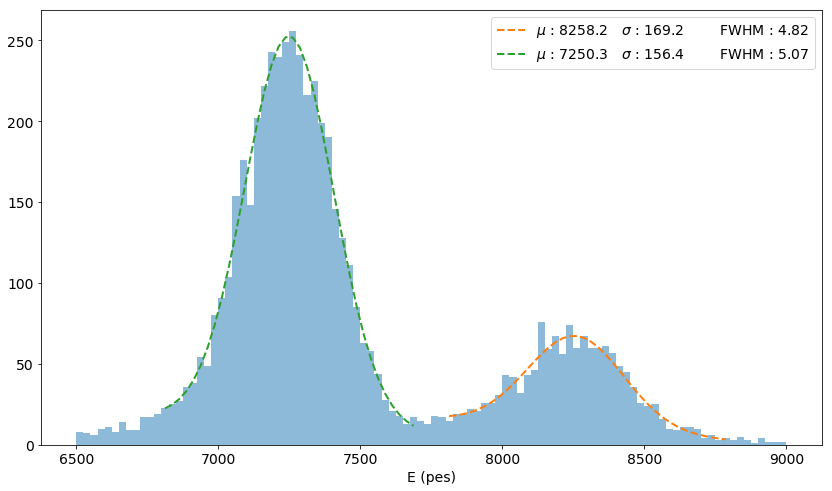

In [210]:
xEa  = hst.Vaxis( (6.5e3, 9.e3), 100)
peaks = ((7.8e3, 8.8e3), (6.8e3, 7.7e3) )
plot_fit_multiple_peaks(xEa, peaks, sel)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


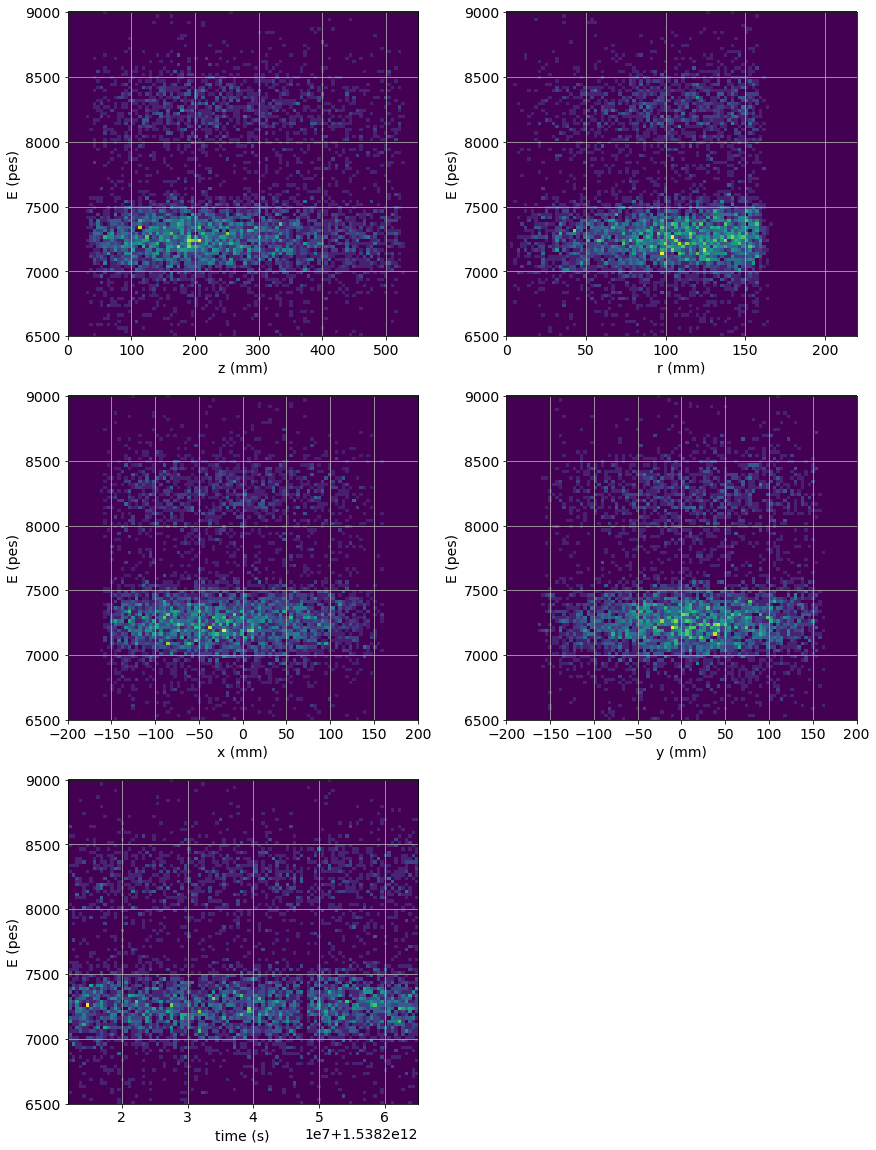

In [212]:
plot_E_vs_vars(xEa, sel)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


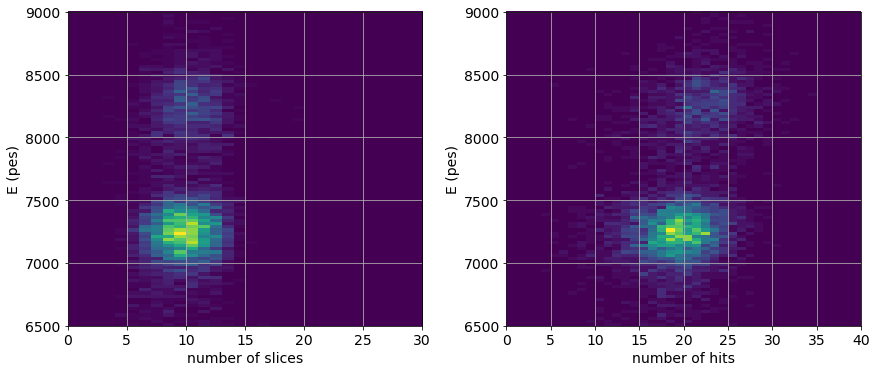

In [215]:
xNSa = hst.Vaxis( (0, 30), 30)
xNHa = hst.Vaxis( (0, 40), 40)
plot_E_vs_N(xEa, xNSa, xNHa, sel)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


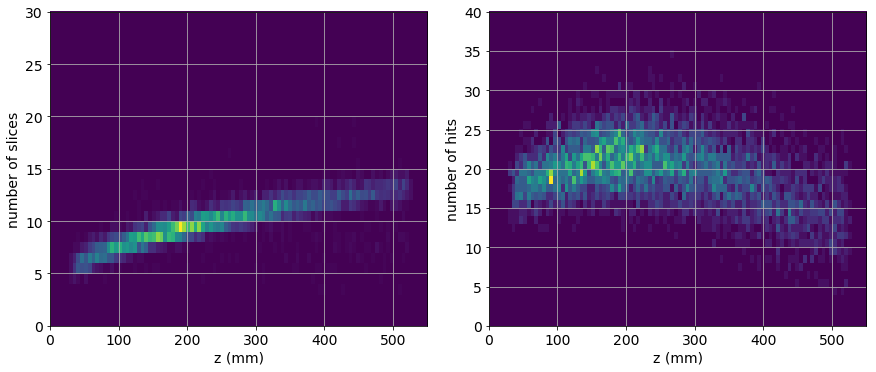

In [218]:
Za = hst.Vaxis( (0., 550.), 100)
plot_N_vs_Z(xEa, Za, xNSa, xNHa, sel)

## Cs

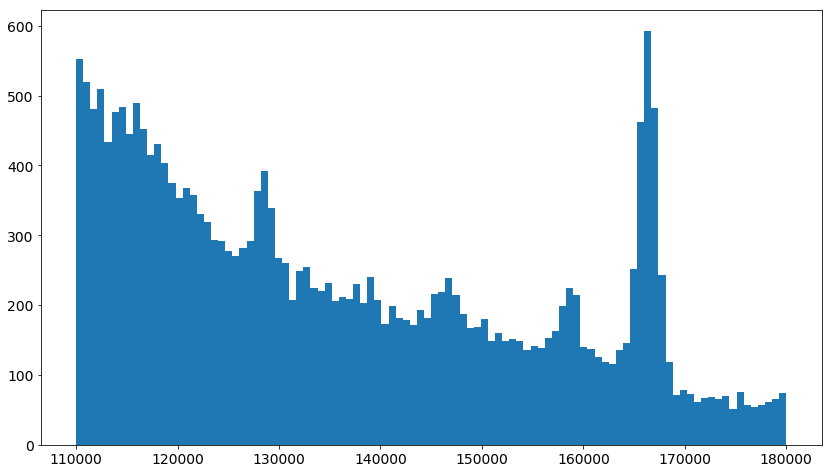

In [219]:
plt.hist(E[sel], 100, (110e3, 180e3));

$\mu$ : 166379.9	 $\sigma$ : 865.7	 FWHM : 1.22
$\mu$ : 158676.5	 $\sigma$ : 916.2	 FWHM : 1.36
$\mu$ : 146621.5	 $\sigma$ : 900.3	 FWHM : 1.44
$\mu$ : 128488.2	 $\sigma$ : 737.1	 FWHM : 1.35


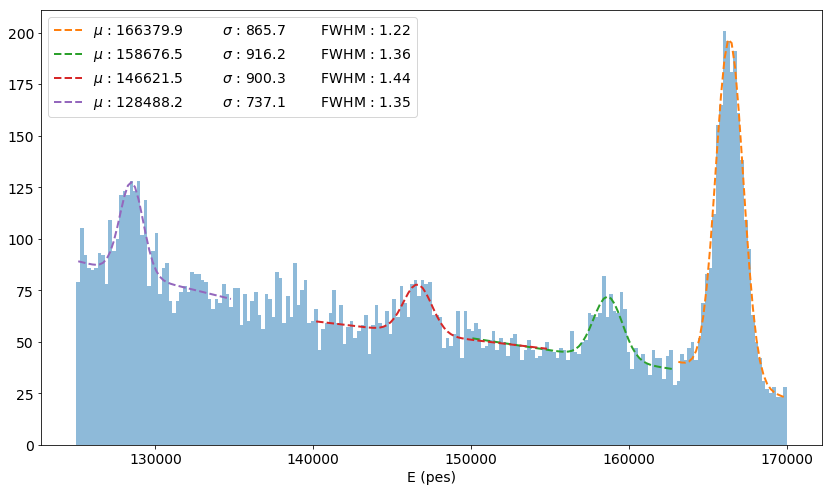

In [221]:
xEa    = hst.Vaxis((125.e3, 170e3), 200)
Erpks = ( (163.e3, 170.e3), (150.e3, 163.e3), (140.e3, 155e3), (125.e3, 135e3) )
plot_fit_multiple_peaks(xEa, Erpks, sel)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


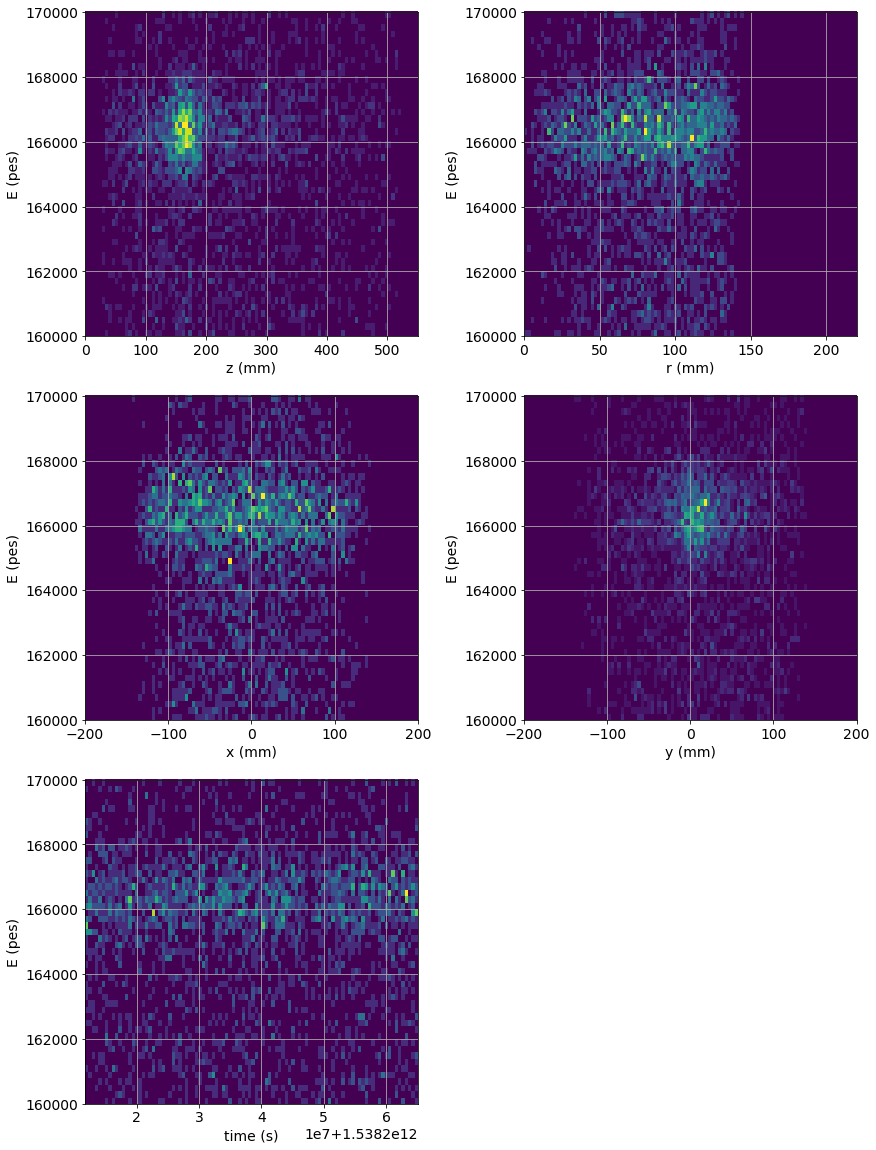

In [222]:
xEa = hst.Vaxis( (160e3, 170e3), 50)
plot_E_vs_vars(xEa, sel)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


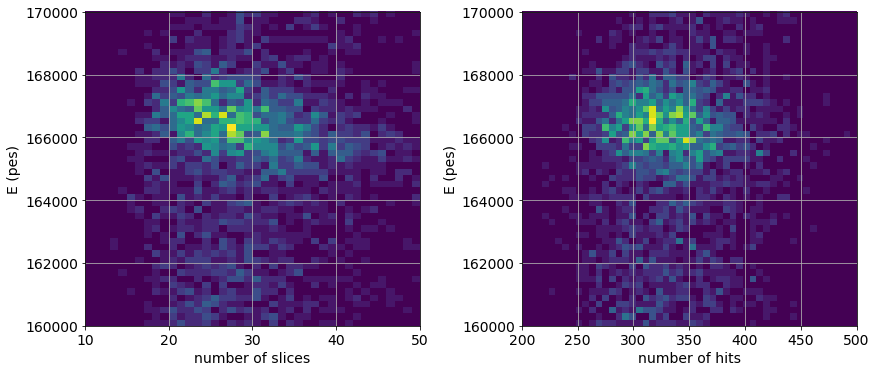

In [223]:
xEa  = hst.Vaxis( (160e3, 170e3), 50)
xNSa = hst.Vaxis( (10, 50), 40)
xNHa = hst.Vaxis( (200, 500), 50)
plot_E_vs_n(xEa, xNSa, xNHa, sel)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


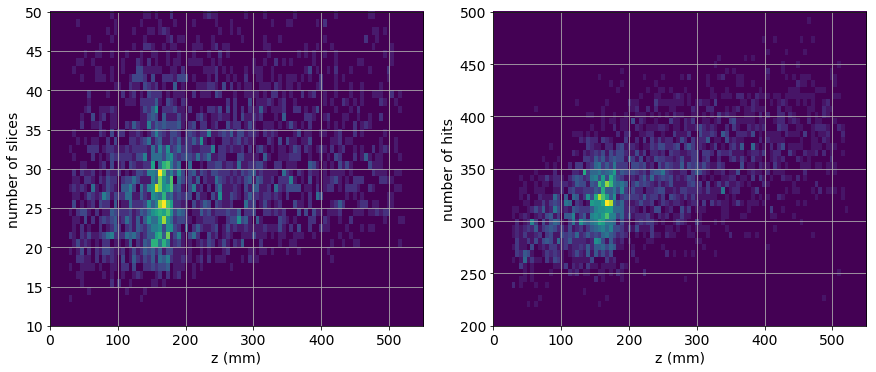

In [225]:
plot_N_vs_Z(xEa, Za, xNSa, xNHa, sel)

## Tl

$\mu$ : 403914.3	 $\sigma$ : 2565.4	 FWHM : 1.49


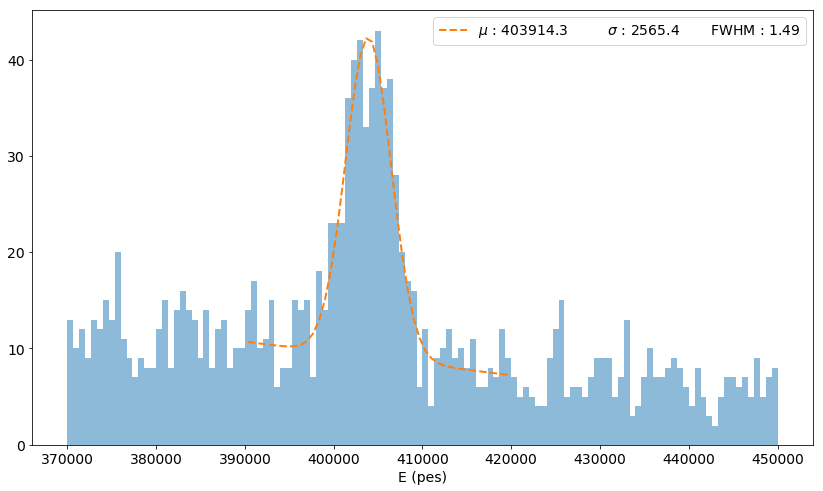

In [227]:
xEa = hst.Vaxis((370e3, 450e3), 120)
peaks = ( (390e3, 420e3), )

plot_fit_multiple_peaks(xEa, peaks, sel)


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


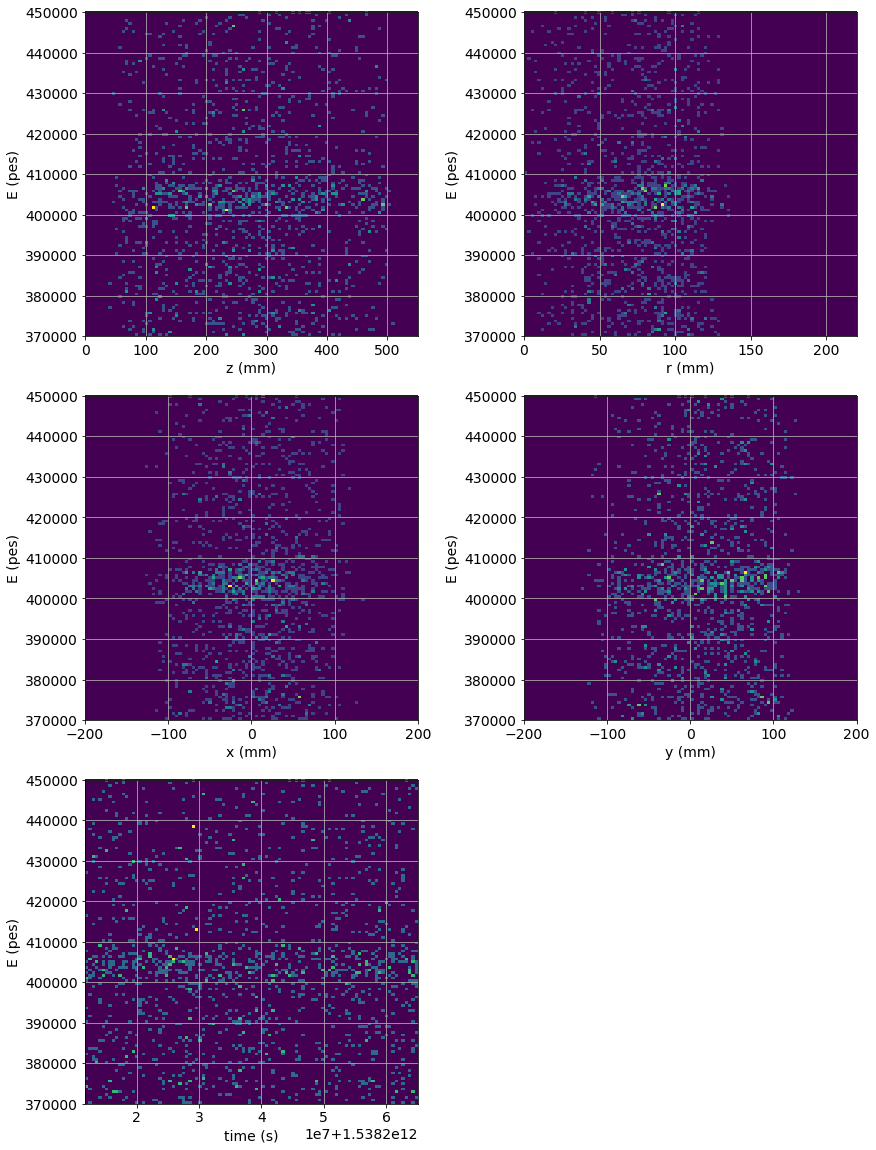

In [228]:
#xEa = hst.Vaxis( (160e3, 170e3), 50)
plot_E_vs_vars(xEa, sel)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


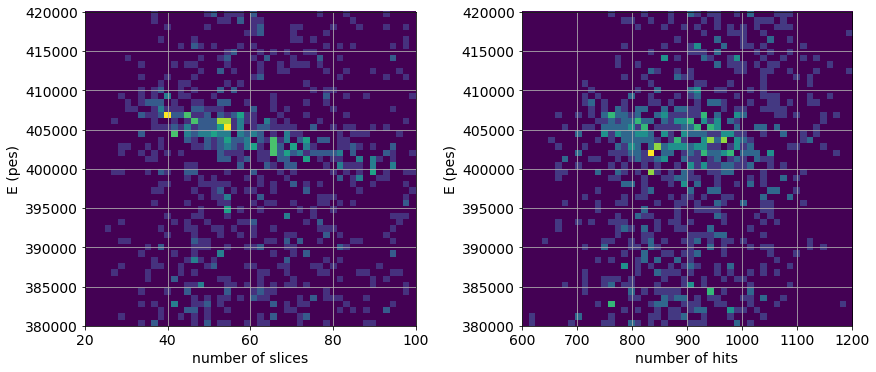

In [230]:
xEa  = hst.Vaxis( (380e3, 420e3), 50)
xNSa = hst.Vaxis( (20, 100), 50)
xNHa = hst.Vaxis( (600, 1200), 50)
plot_E_vs_n(xEa, xNSa, xNHa, sel)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


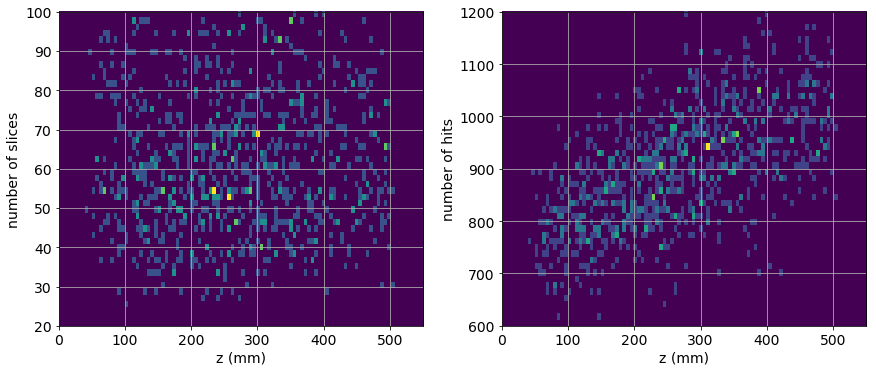

In [231]:
plot_N_vs_Z(xEa, Za, xNSa, xNHa, sel)

## Energy scale and resolution

In [282]:
dat = {'E'  :  [7250.2, 8258.2, 10215., 128488, 146621, 158676, 166380, 403914],
       'sig':  [154.4 ,  169.2,  174.2, 731,    900,    916,    866,   2565],
       'E0' :  [29.7  ,   34.0,   41.5, 510,    583,  633.9,  661.6, 1592.5]}

df = pd.DataFrame(dat)

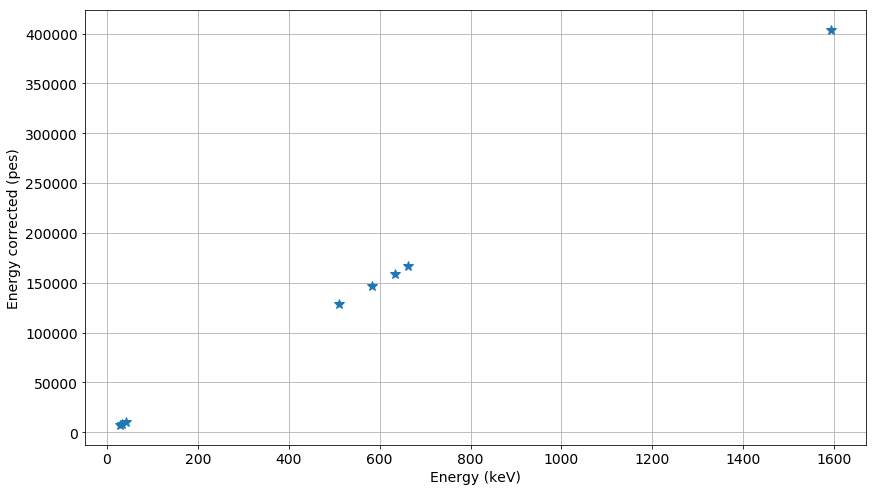

In [283]:
plt.plot(df.E0, df.E, marker='*', markersize=10, ls='')
plt.xlabel('Energy (keV)')
plt.ylabel('Energy corrected (pes)');
plt.grid();

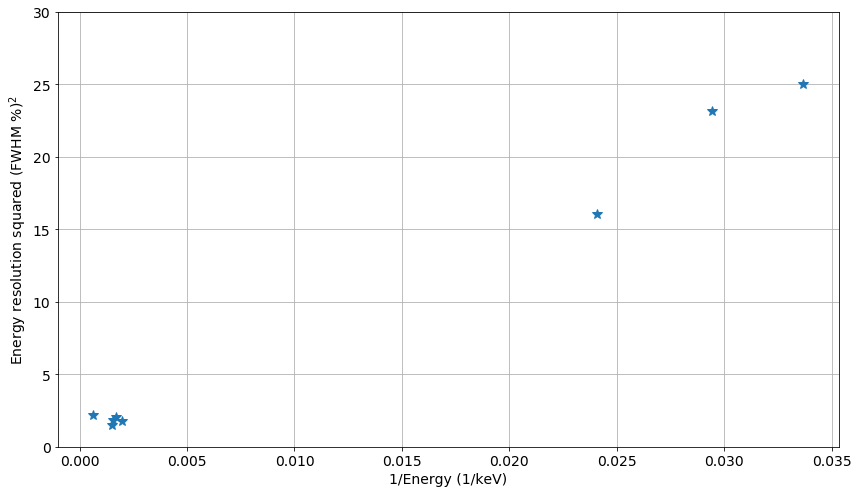

In [284]:
fwhm = 235*df.sig/df.E
plt.plot(1./df.E0, fwhm*fwhm, marker='*', markersize=10, ls='')
plt.xlabel('1/Energy (1/keV)')
plt.ylabel('Energy resolution squared (FWHM %)$^2$')
#plt.xscale('log')
plt.ylim(0., 30.)
plt.grid()